# Image Classification with PyTorch

## Data loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Each sample is a 28x28 image

(<PIL.Image.Image image mode=L size=28x28 at 0x25B8AE83C70>, 5)


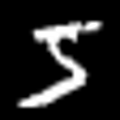

In [2]:
# torchvision contains convinience functions for popular datasets
ds_train = datasets.MNIST('data', train=True, download=True)
# if we index this dataset, we get a single data point: a PIL image and an Integer
print(ds_train[0])
ds_train[0][0].resize((120,120))

Let's transform the data to something that our Pytorch models will understand
for this purpose, we can supply a transform function to the datase

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)

The image is now a `torch.Tensor`

In [4]:
type(ds_train[0][0])

torch.Tensor

The normalization is something you learned about in the lecture. Normalizing with $\mu=0, \sigma=1$ corresponds to no normalization. Let's compute the proper normalization constants!

In [5]:
# lets get only the images 
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [6]:
#########################################################################
# TODO: calculate the mean and std of MNIST images
# hint: to look for operations on pytorch tensor, refer to the official PyTorch docs 
# https://pytorch.org/docs/stable/
#########################################################################
mu = torch.mean(ims_train)
std = torch.std(ims_train)
print(mu)
print(std)

tensor(0.1307)
tensor(0.3081)


We normalize the data as below.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)

In [8]:
ds_train[0][0].min(), ds_train[0][0].max()

(tensor(-0.4241), tensor(2.8215))

Next, we want to receive mini-batches, not only single data points.
We use PyTorch's DataLoader class. Build a dataloader with a batch size of 64 and 4 workers (number of subprocess that peform the dataloading). Important: you need to shuffle the training data, not the test data.

**NOTE**: if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`

In [9]:
BATCH_SIZE = 64
NUM_WORKERS = 4
#########################################################################
# TODO: Build a dataloader for both train and test data.
#########################################################################
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## MLP in Pytorch

Ok, the dataloading works. Let's build our model, PyTorch makes this very easy. We will build replicate the model from our last exercises. However, now, we add another variable called `nLayer` that indicates how many linear layers that in your network. Please adapt your code from last exercise accordingly to allow different number of layers.

In [10]:
# These are the parameters to be used
nInput = 784
nOutput = 10
nLayer = 2
nHidden = 16
act_fn = nn.ReLU()

In [11]:
#########################################################################
# TODO: Implement the __init__ of the MLP class. 
# insert the activation after every linear layer. Important: the number of 
# hidden layers should be variable!
#########################################################################

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = []
        ##### implement this part #####
        for i in range(nLayer+1):
            if i == 0:
                layers.append(nn.Linear(nInput, nHidden, bias=True))
            elif i == nLayer:
                layers.append(nn.Linear(nHidden, nOutput, bias=True))
            else:
                layers.append(nn.Linear(nHidden, nHidden, bias=True))
            # add a activation func after each layer
            layers.append(act_fn)
        ###############################
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

In [14]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(torch.randn(1,1,28,28)).shape # shape of Output

torch.Size([1, 10])

We already implemented the test function for you

In [12]:
def test(model, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    # exclude the test code from the computing graph of the neural network
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

Now you only need to implement the training and you are good to go

In [13]:
#########################################################################
# TODO: Implement the missing part of the training function. As a loss function we want to use cross entropy
# It can be called with F.cross_entropy().
# Hint: Pass through the model -> Backpropagate gradients -> Take gradient step
#########################################################################

def train(model, dl_train, optimizer, epoch, log_interval=100, device='cpu'):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)
        
        # first we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()
        ##### implement this part #####
        output = model(data)
        loss = F.cross_entropy(output, target, reduction='mean')
        loss.backward()
        optimizer.step()
        ###############################

        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)'.format(
        loss, correct, len(dl_train.dataset),
        100. * correct / len(dl_train.dataset)))

Ok, the setup is almost done. The onoly missing part is the optimizer. We are going to use Adam.

In [14]:
# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())
mlp

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
    (5): ReLU()
  )
)

In [17]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 148.693924
Train Epoch: 1 [6400/60000 (11%)]	Loss: 56.552586
Train Epoch: 1 [12800/60000 (21%)]	Loss: 54.187809
Train Epoch: 1 [19200/60000 (32%)]	Loss: 40.441399
Train Epoch: 1 [25600/60000 (43%)]	Loss: 41.231426
Train Epoch: 1 [32000/60000 (53%)]	Loss: 26.226503
Train Epoch: 1 [38400/60000 (64%)]	Loss: 16.124958
Train Epoch: 1 [44800/60000 (75%)]	Loss: 11.142137
Train Epoch: 1 [51200/60000 (85%)]	Loss: 19.126534
Train Epoch: 1 [57600/60000 (96%)]	Loss: 21.478642

Train set: Average loss: 4.1522, Accuracy: 48840/60000 (81.4%)
Test set: Average loss: 0.2934, Accuracy: 9161/10000 (91.610%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 9.383723
Train Epoch: 2 [6400/60000 (11%)]	Loss: 34.124290
Train Epoch: 2 [12800/60000 (21%)]	Loss: 13.906291
Train Epoch: 2 [19200/60000 (32%)]	Loss: 17.101852
Train Epoch: 2 [25600/60000 (43%)]	Loss: 20.081419
Train Epoch: 2 [32000/60000 (53%)]	Loss: 6.734853
Train Epoch: 2 [38400/60000 (64%)]	Loss: 20.262243
Train Epoch: 2 [44

In [15]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325462
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.286584
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.258331
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.875798
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.028116
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.952344
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.742962
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.845561
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.784135
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.899070

Train set: Average loss: 0.9131, Accuracy: 37659/60000 (62.8%)
Test set: Average loss: 0.8898, Accuracy: 6672/10000 (66.720%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.821958
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.967426
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.775489
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.923422
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.879724
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.050835
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.829428
Train Epoch: 2 [44800/60000 (75%)]

After training, you should see test accuracies of > **94%** - By they way, here we report test accuracy, the last exercises reported test error. Accuracy is simply (1 - error). Both metrics are commonly reported, there is no clear preference in literature for one or the other.

Now, can you do some parameter tuning to boost the test accuracy to > **97%**?

In [32]:
#########################################################################
#TODO: modify the parameters below to see which setting that you can get to 97%
#########################################################################
nLayer = 4
nHidden = 36
act_fn = nn.LeakyReLU(negative_slope=0.012)

# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
mlp

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=36, bias=True)
    (1): LeakyReLU(negative_slope=0.012)
    (2): Linear(in_features=36, out_features=36, bias=True)
    (3): LeakyReLU(negative_slope=0.012)
    (4): Linear(in_features=36, out_features=36, bias=True)
    (5): LeakyReLU(negative_slope=0.012)
    (6): Linear(in_features=36, out_features=36, bias=True)
    (7): LeakyReLU(negative_slope=0.012)
    (8): Linear(in_features=36, out_features=10, bias=True)
    (9): LeakyReLU(negative_slope=0.012)
  )
)

In [33]:
epochs = 12
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 147.392700
Train Epoch: 1 [6400/60000 (11%)]	Loss: 50.698074
Train Epoch: 1 [12800/60000 (21%)]	Loss: 53.416473
Train Epoch: 1 [19200/60000 (32%)]	Loss: 18.240850
Train Epoch: 1 [25600/60000 (43%)]	Loss: 18.857492
Train Epoch: 1 [32000/60000 (53%)]	Loss: 21.520359
Train Epoch: 1 [38400/60000 (64%)]	Loss: 12.482315
Train Epoch: 1 [44800/60000 (75%)]	Loss: 31.633074
Train Epoch: 1 [51200/60000 (85%)]	Loss: 14.762682
Train Epoch: 1 [57600/60000 (96%)]	Loss: 6.428107

Train set: Average loss: 6.6286, Accuracy: 51039/60000 (85.1%)
Test set: Average loss: 0.2465, Accuracy: 9248/10000 (92.480%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 17.502737
Train Epoch: 2 [6400/60000 (11%)]	Loss: 5.054456
Train Epoch: 2 [12800/60000 (21%)]	Loss: 14.767605
Train Epoch: 2 [19200/60000 (32%)]	Loss: 13.855268
Train Epoch: 2 [25600/60000 (43%)]	Loss: 5.353417
Train Epoch: 2 [32000/60000 (53%)]	Loss: 7.675358
Train Epoch: 2 [38400/60000 (64%)]	Loss: 12.876953
Train Epoch: 2 [4480

Before you move on to the next exercise, you can further play with the other parameters (learning rate, epochs, a different optimizer, etc.) to get a feeling what can improve or hamper performance. 

## CNN
Alright, we matched our prior performance. Let's surpass it! You will soon see the power of CNN by building a small one yourself. The structure should be as follows

| CNN Architecture                             	|
|----------------------------------------------	|
| Conv: $C_{in}=1, C_{out}=32, K=3, S=1, P=0$  	|
| ReLU                                         	|
| Conv: $C_{in}=32, C_{out}=64, K=3, S=1, P=0$ 	|
| ReLU                                         	|
| MaxPool2d: $K=2, S=2, P=0$                   	|
| Dropout: $p=0.25$                            	|
| Linear: $C_{in}=9216, C_{out}=128$           	|
| ReLU                                         	|
| Dropout: $p=0.5$                             	|
| Linear: $C_{in}=128, C_{out}=10$             	|

The layers you will need are: 

`nn.Conv2d,  nn.Linear,  nn.Dropout, nn.MaxPool2d, nn.Flatten`

For layers without parameters you can alternatively use function in the forward pass:  

`F.max_pool2d, torch.flatten`

In [19]:
#########################################################################
# TODO: Implement the __init__ and forward method of the CNN class. 
# Hint: do not forget to flatten the appropriate dimension after the convolutional blocks. 
# A linear layers expect input of the size (B, H) with batch size B and feature size H
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # input 1 x 1 x 28 x 28
        Conv_Layers = [
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p=0.25),
        ]
        Linear_Layers = [
            nn.Linear(9216, 128, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 10, bias=True)
        ]

        self.Conv_Layers = nn.Sequential(*Conv_Layers)
        self.Linear_Layers = nn.Sequential(*Linear_Layers)

    def forward(self, x):
        x = self.Conv_Layers(x) # torch.Size([1, 64, 12, 12])
        x = torch.flatten(x, 1, 3) # torch.Size([1, 9216])
        x = self.Linear_Layers(x) # torch.Size([1, 10])
        return x


In [20]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape

torch.Size([1, 10])

Alright, let's train!

In [21]:
optimizer = optim.Adam(cnn.parameters())

epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 147.278137
Train Epoch: 1 [6400/60000 (11%)]	Loss: 19.479948
Train Epoch: 1 [12800/60000 (21%)]	Loss: 11.513387
Train Epoch: 1 [19200/60000 (32%)]	Loss: 8.942716
Train Epoch: 1 [25600/60000 (43%)]	Loss: 7.468635
Train Epoch: 1 [32000/60000 (53%)]	Loss: 11.931755
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.059907
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.665296
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.712665
Train Epoch: 1 [57600/60000 (96%)]	Loss: 7.385027

Train set: Average loss: 2.0670, Accuracy: 56496/60000 (94.2%)
Test set: Average loss: 0.0458, Accuracy: 9849/10000 (98.490%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 7.406923
Train Epoch: 2 [6400/60000 (11%)]	Loss: 3.674722
Train Epoch: 2 [12800/60000 (21%)]	Loss: 4.043659
Train Epoch: 2 [19200/60000 (32%)]	Loss: 16.160927
Train Epoch: 2 [25600/60000 (43%)]	Loss: 6.547708
Train Epoch: 2 [32000/60000 (53%)]	Loss: 3.997545
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.590868
Train Epoch: 2 [44800/60000 

This will probably take a bit longer to train, as a convolutional network is not very efficient on a CPU. The current settings should get you around **99%** accuracy. Nice! 
Again, you should try different hyperparameters and see how far you can push the performance.

### Inline Question

If your model weight is randomly initalized, and no training is done as above. What accuracy do you think the model will get for a 10-class classification task in theory?

**Your answer**: less than 50%


## Training on CIFAR10

Now we are going to move to something more challenging - CIFAR10. We can reuse most of the code above. Thankfully, CIFAR is also a popular dataset, so we can again make use of a PyTorch convience function.

In [15]:
ds_train = datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


This dataset is not normalized yet, so we need to calculate the normalization constants.

In [16]:
ims_train = torch.tensor(ds_train.data)
ims_train = ims_train.float() / 255.
#########################################################################
# TODO: calculate the mean and std of CIFAR
# hint: We want the mean and std of the channel dimension, these should
# be 3 dimensional
#########################################################################
mu_CIFAR = torch.mean(ims_train, dim=(0,1,2))
std_CIFAR = torch.std(ims_train, dim=(0,1,2))
print(mu_CIFAR)
print(std_CIFAR)

tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


For CIFAR we want to make use of data augmentation to improve generalization. You will find all data augmentations data are included in torchvision here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [17]:
BATCH_SIZE = 128
NUM_WORKERS = 4 # if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`
#########################################################################
# TODO: Implement the proper transforms for the training and test dataloaders. 
# Then build train and test dataloaders with batch size 128 and 4 workers
#
# Train: 
# - Apply a random crop with size 32 on a padded version of the image with P=4
# - Flip the image horizontally with a probability of 40 %
# - Transform to a Tensor
# - Normalize with the constants calculated above
# Test: 
# - Transform to a Tensor
# - Normalize with the constants calculated above
#########################################################################
torch.manual_seed(17)

transform_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=[4], padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mu_CIFAR, std_CIFAR)
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu_CIFAR, std_CIFAR)
])

CIFAR10_train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
CIFAR10_test_data = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

CIFAR10_train = DataLoader(CIFAR10_train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
CIFAR10_test = DataLoader(CIFAR10_test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


Setting up the  optimizer, this time we use SGD. The scheduler adapts the learning rate during traing (you can ignore it)

In [26]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, CIFAR10_train, optimizer, epoch, log_interval=100)
    test(cnn, CIFAR10_test)    
    scheduler.step()

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead

This will not work. You should see the following error message

```
Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead
```

This error is telling us that something is not right in the definition of our model. Copy the CNN class from above and make changes, so the training works.

In [25]:
#########################################################################
# TODO: Adapt the definition from the CNN class above to work on CIFAR.
# You can copy and run the following prompt for evaluation:
# CNN()(torch.randn(1,3,32,32)).shape
# It should print 'torch.Size([1, 10])'
# Hint: You need to change 2 things. 
#########################################################################

class CNN_CIFAR(nn.Module):
    def __init__(self):
        super(CNN_CIFAR, self).__init__()
        # input 1 x 3 x 32 x 32
        Conv_Layers = [
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p=0.25),
        ]
        Linear_Layers = [
            nn.Linear(12544, 128, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 10, bias=True)
        ]

        self.Conv_Layers = nn.Sequential(*Conv_Layers)
        self.Linear_Layers = nn.Sequential(*Linear_Layers)

    def forward(self, x):
        x = self.Conv_Layers(x) # torch.Size([1, 64, 14, 14])
        x = torch.flatten(x, 1, 3) # torch.Size([1, 12544])
        x = self.Linear_Layers(x) # torch.Size([1, 10])
        return x

In [38]:
CNN_CIFAR()(torch.randn(1,3,32,32)).shape

torch.Size([1, 10])

Let's try again

In [39]:
cnn_CIFAR = CNN_CIFAR()
optimizer = optim.SGD(cnn_CIFAR.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn_CIFAR, CIFAR10_train, optimizer, epoch, log_interval=100)
    test(cnn_CIFAR, CIFAR10_test)
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 296.299835
Train Epoch: 1 [12800/50000 (26%)]	Loss: 292.769257
Train Epoch: 1 [25600/50000 (51%)]	Loss: 291.932983
Train Epoch: 1 [38400/50000 (77%)]	Loss: 273.779510

Train set: Average loss: 159.0242, Accuracy: 8488/50000 (17.0%)
Test set: Average loss: 2.0181, Accuracy: 2342/10000 (23.420%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 271.065033
Train Epoch: 2 [12800/50000 (26%)]	Loss: 235.294449
Train Epoch: 2 [25600/50000 (51%)]	Loss: 241.890991
Train Epoch: 2 [38400/50000 (77%)]	Loss: 229.940475

Train set: Average loss: 141.5549, Accuracy: 13636/50000 (27.3%)
Test set: Average loss: 1.7318, Accuracy: 3586/10000 (35.860%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 246.941055
Train Epoch: 3 [12800/50000 (26%)]	Loss: 232.051758
Train Epoch: 3 [25600/50000 (51%)]	Loss: 242.513992
Train Epoch: 3 [38400/50000 (77%)]	Loss: 226.533783

Train set: Average loss: 148.7781, Accuracy: 15803/50000 (31.6%)
Test set: Average loss: 1.6222, Accuracy: 3916/10000 (39.160%)

Tr

This should give 40 - 50 % - and if you are not already on Colab it will give you a stressed out laptop. The performance is a lot better than random, but we can definitely do better.

### Have fun with GPUs
You can already call it a day until this point because we won't grade the rest of the excecise. You can have more fun with the rest :)


In [6]:
print(torch.__version__)

1.12.0+cu116


If you didn't already, move to colab. To use a GPU, follow on the collaboratory menu tabs, "Runtime" => "Change runtime type" and set it to GPU. Then run the same training loop but now on GPU. 

In [27]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

cnn_CIFAR = CNN_CIFAR()
optimizer = optim.SGD(cnn_CIFAR.parameters(), lr=0.0005, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn_CIFAR = cnn_CIFAR.to(device)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn_CIFAR, CIFAR10_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn_CIFAR, CIFAR10_test, device=device)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 295.505066
Train Epoch: 1 [12800/50000 (26%)]	Loss: 234.099258
Train Epoch: 1 [25600/50000 (51%)]	Loss: 213.830414
Train Epoch: 1 [38400/50000 (77%)]	Loss: 208.442108

Train set: Average loss: 132.4573, Accuracy: 17111/50000 (34.2%)
Test set: Average loss: 1.4678, Accuracy: 4753/10000 (47.530%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 213.440460
Train Epoch: 2 [12800/50000 (26%)]	Loss: 187.561249
Train Epoch: 2 [25600/50000 (51%)]	Loss: 200.927078
Train Epoch: 2 [38400/50000 (77%)]	Loss: 205.552582

Train set: Average loss: 128.9967, Accuracy: 21503/50000 (43.0%)
Test set: Average loss: 1.3450, Accuracy: 5169/10000 (51.690%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 200.237640
Train Epoch: 3 [12800/50000 (26%)]	Loss: 161.648117
Train Epoch: 3 [25600/50000 (51%)]	Loss: 197.594391
Train Epoch: 3 [38400/50000 (77%)]	Loss: 180.726288

Train set: Average loss: 101.8391, Accuracy: 22858/50000 (45.7%)
Test set: Average loss: 1.2867, Accuracy: 5164/10000 (51.640%)

T

This should be way faster now. But the true advantage of the GPU is that we can use much bigger models now and still train them in a reasonable amount of time. PyTorch is again very handy. The torchvision library comes with varies state-of-the-art model architectures, some of which you have seen in the lecture.

In [29]:
from torchvision.models import resnet18
cnn_ResNet = resnet18()
print(cnn_ResNet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Looks scary! But the only thing you need to change to make it work on CIFAR is the last layer.
Currently the last layer is:
```
  (fc): Linear(in_features=512, out_features=1000, bias=True)
```
out_features is the number of classes. This models are developed for Imagenet, a dataset with 1000 classes. So this part of the model you need to adapt. Additionally, you need to add a log-softmax layer again, as we us negative log-likelihood as the training criterion. 

In [30]:
#########################################################################
# TODO: Adapt the Resnet to work on CIFAR
#########################################################################
cnn_ResNet.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=10, bias=True),
    nn.LogSoftmax(dim=1)
)

In [31]:
# This should print 'torch.Size([16, 10])'
cnn_ResNet(torch.randn(16,3,32,32)).shape

torch.Size([16, 10])

In [32]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # this gives us additional speed up

optimizer = optim.SGD(cnn_ResNet.parameters(), lr=0.0005, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn_ResNet = cnn_ResNet.to(device)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn_ResNet, CIFAR10_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn_ResNet, CIFAR10_test, device=device)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 321.710449
Train Epoch: 1 [12800/50000 (26%)]	Loss: 255.063126
Train Epoch: 1 [25600/50000 (51%)]	Loss: 226.124557
Train Epoch: 1 [38400/50000 (77%)]	Loss: 212.154129

Train set: Average loss: 114.6153, Accuracy: 18231/50000 (36.5%)
Test set: Average loss: 1.4528, Accuracy: 4707/10000 (47.070%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 181.595886
Train Epoch: 2 [12800/50000 (26%)]	Loss: 185.198746
Train Epoch: 2 [25600/50000 (51%)]	Loss: 183.346039
Train Epoch: 2 [38400/50000 (77%)]	Loss: 162.819351

Train set: Average loss: 115.9327, Accuracy: 24805/50000 (49.6%)
Test set: Average loss: 1.3417, Accuracy: 5444/10000 (54.440%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 173.480865
Train Epoch: 3 [12800/50000 (26%)]	Loss: 153.651184
Train Epoch: 3 [25600/50000 (51%)]	Loss: 144.317032
Train Epoch: 3 [38400/50000 (77%)]	Loss: 152.602173

Train set: Average loss: 96.2579, Accuracy: 28353/50000 (56.7%)
Test set: Average loss: 1.1051, Accuracy: 6083/10000 (60.830%)

Tr

This should get us well above 75%, the best we got was ~ 80%.

Now, use different torchvision architectures, different optimizers (Adam is always a good choice), data augmentation techniques, and hyperparameter search to achieve a test accuracy of >90 %

In [33]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # this gives us additional speed up

optimizer = optim.Adam(cnn_ResNet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn_ResNet = cnn_ResNet.to(device)

epochs = 15
for epoch in range(1, epochs + 1):
    train(cnn_ResNet, CIFAR10_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn_ResNet, CIFAR10_test, device=device)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 90.251366
Train Epoch: 1 [12800/50000 (26%)]	Loss: 93.445061
Train Epoch: 1 [25600/50000 (51%)]	Loss: 86.350266
Train Epoch: 1 [38400/50000 (77%)]	Loss: 95.243782

Train set: Average loss: 56.3426, Accuracy: 37241/50000 (74.5%)
Test set: Average loss: 0.6840, Accuracy: 7607/10000 (76.070%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 92.669662
Train Epoch: 2 [12800/50000 (26%)]	Loss: 87.093178
Train Epoch: 2 [25600/50000 (51%)]	Loss: 99.349716
Train Epoch: 2 [38400/50000 (77%)]	Loss: 88.217712

Train set: Average loss: 62.5187, Accuracy: 37983/50000 (76.0%)
Test set: Average loss: 0.7134, Accuracy: 7545/10000 (75.450%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 73.502983
Train Epoch: 3 [12800/50000 (26%)]	Loss: 88.952629
Train Epoch: 3 [25600/50000 (51%)]	Loss: 102.398209
Train Epoch: 3 [38400/50000 (77%)]	Loss: 69.493919

Train set: Average loss: 54.6655, Accuracy: 38684/50000 (77.4%)
Test set: Average loss: 0.6609, Accuracy: 7668/10000 (76.680%)

Train Epoch: 4 